
# Using Augraphy in Pytorch deep learning pipeline augmentation process.

In this example, a classifier will be trained in [Pytorch](https://pytorch.org/) deep learning framework to classify between clean and dirty document images. 

[Augraphy](https://github.com/sparkfish/augraphy) will be used to augment the clean images and generate the dirty set of images.

[Transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) is applied on a [Resnet](https://pytorch.org/hub/pytorch_vision_resnet/) model to further fine tune it in classifying the images into "dirty" and "clean".

 The image dataset is extracted from a Kaggle document denoising competition: [Denoising ShabbyPages](https://www.kaggle.com/competitions/denoising-shabby-pages).

1. The first step is to download the image dataset. We are using [gdown](https://github.com/wkentaro/gdown) to download the data here.

In [ ]:
# download and unzip document image data

!gdown --id 1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu
!unzip shabby_small.zip

2. Next, we install the latest version of Augraphy from their repository.

In [ ]:
# Install  Augraphy, the main image augmentation library

!pip install git+https://github.com/sparkfish/augraphy

3. Then, we import some basic and Pytorch related libraries.

In [ ]:
# import libraries

import sys
import glob
import cv2
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

from torch.autograd import Variable

from matplotlib import pyplot as plt
from time import time


4. The next step is to create an Augrahpy augmentation pipeline. We can use `from augraphy import *` to import all the necessary functions and modules. 
  
  An Augraphy pipeline consists of 3 phases (ink, paper and post), and we use `AugraphyPipeline(ink_phase, paper_phase, post_phase)` to initialize the pipeline instance. 

  Each `ink_phase`, `paper_phase` and `post_phase` is a `list` contains all of the augmentation instances. In this example, we will be using a simple augmentation pipeline and they will be using the augmentation default parameters.

In [ ]:
# create an Augraphy augmentation pipeline

from augraphy import *

ink_phase = [Dithering(p=0.5),
             InkBleed(p=0.5),
             OneOf([LowInkRandomLines(p=1), LowInkPeriodicLines(p=1)]),
            ]

paper_phase = [ColorPaper(p=0.5)]

post_phase = [Markup(p=0.25),
              DirtyRollers(p=0.25),
              Scribbles(p=0.25),
              BindingsAndFasteners(p=0.25),
              BadPhotoCopy(p=0.25),
              DirtyDrum(p=0.25),
              ]

augmentation_pipeline = AugraphyPipeline(ink_phase, paper_phase, post_phase)


5. Different set of image data requires a different transformation object. For clean images, `To_BGR` and `To_Tensor` are used to convert input image from PIL image into numpy image (in BGR channels). By using `datasets.ImageFolder`, images are in PIL format, so we need to convert it to numpy image (in BGR channels) here.

  For dirty images, other than `To_BGR` and `To_Tensor`, we have an additional `augmentation_pipeline` to augment the image and generate dirty effect.

In [ ]:
# create augmentation object

class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        #if len(image.shape)>2:
        #    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if len(image.shape)<3:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        image = image.reshape(3, image.shape[0], image.shape[1])

        return torch.from_numpy(image.astype("float64")/255)

class To_BGR(object):
    """Convert from PIL RGB Image to numpy array BGR image."""
    def __call__(self, image):
        # convert from PIL RGB to BGR
        image_numpy = np.array(image)
        if len(image_numpy.shape)<3:
            return cv2.cvtColor(image_numpy, cv2.COLOR_GRAY2BGR)
        else:
            return cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR)

# augmentations for clean and dirty images
dirty_transforms = transforms.Compose([To_BGR(),
                                       augmentation_pipeline,
                                       To_Tensor()])
clean_transforms = transforms.Compose([To_BGR(), To_Tensor()])
    

6. Before the training, we need to define some training parameters such as `batch_size`, `epochs`, `shuffle` and `image_size`. For the `batch_size` value, the actual value will be 2 times of this value because we load a single batch of clean and dirty images in a single iteration, and they will be merged before we parse them into the training step.

In [ ]:
# training parameters

# actual batch size will be x2 of this, due to clean+dirty images
batch_size = 16  
epochs = 60
shuffle=False
image_size = 400

7. `datasets.ImageFolder` is used to load training images from their folder and create the dataset. We have a separated transform object `dirty_transforms` for dirty images and `clean_transforms` for clean images.

  `torch.utils.data.DataLoader` is used to create the dataloader of the training from the created dataset.



In [ ]:
# Create datasets

train_dirty_path = "/content/shabby_small/train/train_dirty/"
train_clean_path = "/content/shabby_small/train/train_clean/"

validate_dirty_path = "/content/shabby_small/validate/validate_dirty/"
validate_clean_path = "/content/shabby_small/validate/validate_clean/"

test_dirty_path = "/content/shabby_small/test/test_dirty/"
test_clean_path = "/content/shabby_small/test/test_clean/"

# create datasets
train_dirty_data = datasets.ImageFolder(train_dirty_path,transform=dirty_transforms)
train_clean_data = datasets.ImageFolder(train_clean_path,transform=clean_transforms)
validate_dirty_data = datasets.ImageFolder(validate_dirty_path,transform=dirty_transforms)
validate_clean_data = datasets.ImageFolder(validate_clean_path,transform=clean_transforms)
test_dirty_data = datasets.ImageFolder(test_dirty_path,transform=dirty_transforms)
test_clean_data = datasets.ImageFolder(test_clean_path,transform=clean_transforms)

# create dataloader
train_dirty_loader = torch.utils.data.DataLoader(train_dirty_data, shuffle = shuffle, batch_size=batch_size)
train_clean_loader = torch.utils.data.DataLoader(train_clean_data, shuffle = shuffle, batch_size=batch_size)
validate_dirty_loader = torch.utils.data.DataLoader(validate_dirty_data, shuffle = shuffle, batch_size=batch_size)
validate_clean_loader = torch.utils.data.DataLoader(validate_clean_data, shuffle = shuffle, batch_size=batch_size)
test_dirty_loader = torch.utils.data.DataLoader(test_dirty_data, shuffle = shuffle, batch_size=batch_size)
test_clean_loader = torch.utils.data.DataLoader(test_clean_data, shuffle = shuffle, batch_size=batch_size)


8. Here, we check and make sure the images are loaded and augmented correctly by visual inspection.

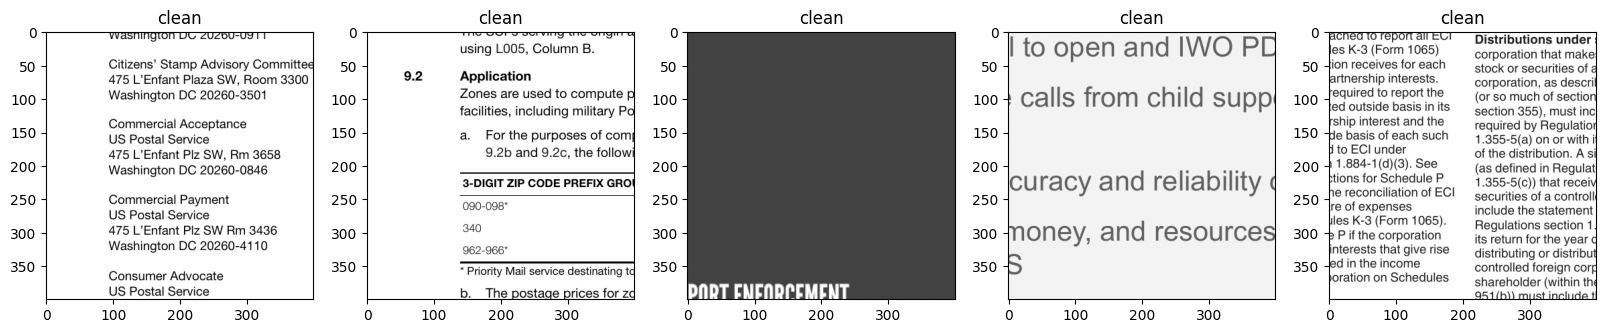

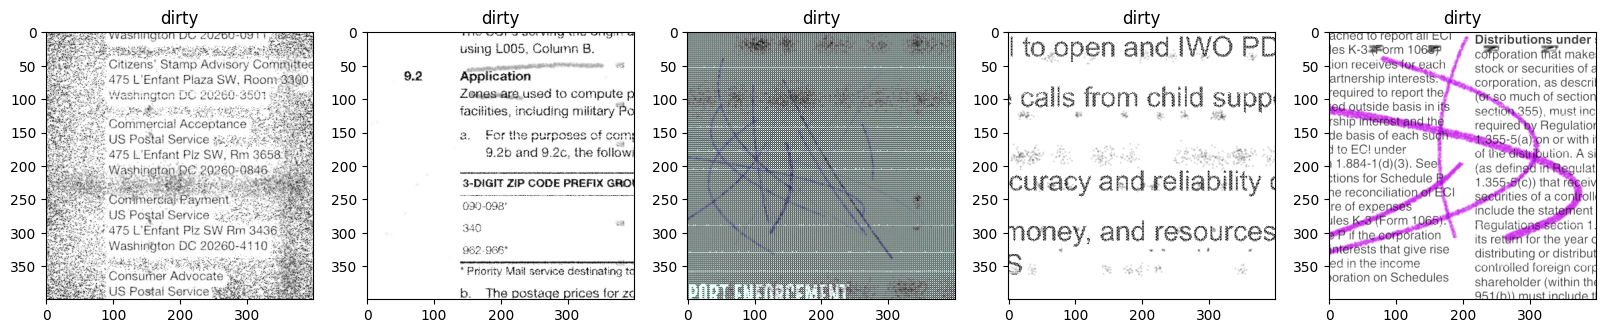

In [ ]:
# Display some of the clean and dirty images

plt.rcParams["figure.figsize"] = (20,20)
# clean
for data in train_clean_loader:
    plt.figure()
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(data[0][i].reshape(image_size, image_size, 3))
        plt.title("clean")
    break

# dirty
for data in train_dirty_loader:
    plt.figure()
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(data[0][i].reshape(image_size, image_size, 3))
        plt.title("dirty")
    break


9. We are using Resnet in the transfer learning process. From Pytorch framework, we can import it by using `models.resnet50(pretrained=True)`. Then, we need to freeze the existing model parameters and add a fully connected layer for training purpose. The loss function is `BCEWithLogitsLoss` because we need a sigmoid layer for binary classification problem.

In [ ]:
# Define training and model parameters
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model
model =models.resnet50(pretrained=True)
#freeze all params
for params in model.parameters():
  params.requires_grad_ = False
# add final layer based on current final layer inputs to single classification output
model.fc = nn.Linear(model.fc.in_features, 1) 
model = model.to(device)

# define optimizer and loss function
criterion = BCEWithLogitsLoss()  # with sigmoid
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.2MB/s]


10. The model training process includes an early stopping feature and the validation data evaluations. In both of the training and validation iterations, we merge each batch dirty and clean images before parsing them to the model so that each batch has a same number of clean and dirty images.

In [ ]:
# training iterations

train_losses = []
validate_losses = []

patient_count = 0
patient_threshold = 10

best_validate_loss = 100

for epoch in range(epochs):
    train_loss = 0
    start_time = time()

    # reset to training mode
    model.train()

    for batch_number, (noisy_samples, clean_samples) in enumerate(zip(train_dirty_loader, train_clean_loader)):
        
        
        noisy_data = noisy_samples[0].float()
        noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float()
        clean_data = clean_samples[0].float()
        clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float()

        # combine clean and dirty image
        all_data = torch.cat([noisy_data, clean_data], dim=0).to(device)
        all_labels = torch.cat([noisy_label, clean_label]).reshape(all_data.shape[0], 1).to(device)

        optimizer.zero_grad()
        
        # forward pass
        predicted_labels = model(all_data)
        
        # compute loss
        loss = criterion(predicted_labels, all_labels)
        train_loss += loss.cpu().data.item()

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

    # append each epoch training loss
    average_train_loss = train_loss/(len(train_dirty_loader) + len(train_clean_loader) )
    train_losses.append(average_train_loss)

    # evaluate model:
    model.eval()
    with torch.no_grad():

        validate_loss = 0

        for batch_number, (noisy_samples, clean_samples) in enumerate(zip(validate_dirty_loader, validate_clean_loader)):

            noisy_data = noisy_samples[0].float()
            noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float()
            clean_data = clean_samples[0].float()
            clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float()

            # combine clean and dirty image
            all_data = torch.cat([noisy_data, clean_data], dim=0).to(device)
            all_labels = torch.cat([noisy_label, clean_label]).reshape(all_data.shape[0], 1).to(device)
            
            # forward pass
            predicted_labels = model(all_data)
            
            # compute loss
            loss = criterion(predicted_labels, all_labels)
            validate_loss += loss.cpu().data.item()

        # append each epoch validate loss
        average_validate_loss = validate_loss/(len(validate_dirty_loader) + len(validate_clean_loader))
        validate_losses.append(average_validate_loss)

    # EARLY STOPPING
    if average_validate_loss<=best_validate_loss:
        best_validate_loss = average_validate_loss
        patient_count = 0
    else:
        patient_count += 1
        if patient_count > patient_threshold:
            break

    print("Epoch = "+str(epoch)+", train_loss = "+str(average_train_loss)+", validate_loss = "+str(average_validate_loss)+", training duration = "+str(round(time()-start_time))+" seconds")


Epoch = 0, train_loss = 0.21099647461641124, validate_loss = 0.14880535202591041, training duration = 262 seconds
Epoch = 1, train_loss = 0.12047027287686743, validate_loss = 0.11462952824015367, training duration = 259 seconds
Epoch = 2, train_loss = 0.10298599175563673, validate_loss = 0.101633113661879, training duration = 302 seconds
Epoch = 3, train_loss = 0.08974477503357864, validate_loss = 0.11230897236811488, training duration = 267 seconds
Epoch = 4, train_loss = 0.09167736405279578, validate_loss = 0.08048696404224948, training duration = 276 seconds
Epoch = 5, train_loss = 0.07554118735034292, validate_loss = 0.08336169311874791, training duration = 276 seconds
Epoch = 6, train_loss = 0.07708208390125414, validate_loss = 0.08516878869972731, training duration = 249 seconds
Epoch = 7, train_loss = 0.08059444746411429, validate_loss = 0.09785231379301924, training duration = 223 seconds
Epoch = 8, train_loss = 0.07325477616452589, validate_loss = 0.07288377016390625, training

11. Once the training is done, loss curve is plotted.

(0.0, 0.2)

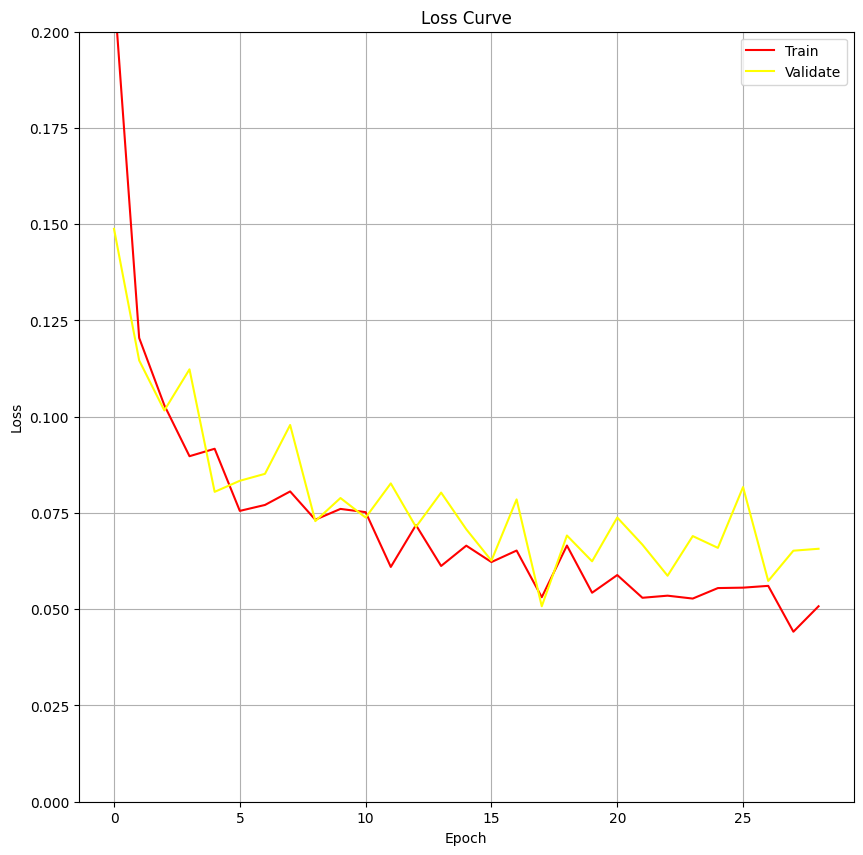

In [ ]:
# Display loss curve

x_train = [n for n in range(len(train_losses))]
x_validate = [n for n in range(len(validate_losses))]
plt.rcParams["figure.figsize"] = (10,10)

plt.figure()
plt.grid()
plt.plot(x_train, train_losses,  color="red", label="Train")
plt.plot(x_validate, validate_losses,  color="yellow", label="Validate")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.ylim(0, 0.2)

12. The last step is to test the trained model. The score the prediction is set at 0.5, so that any score > 0.5 is dirty image, while any score < 0.5 is a clean iamge. From the results, We can see the model is doing pretty well.

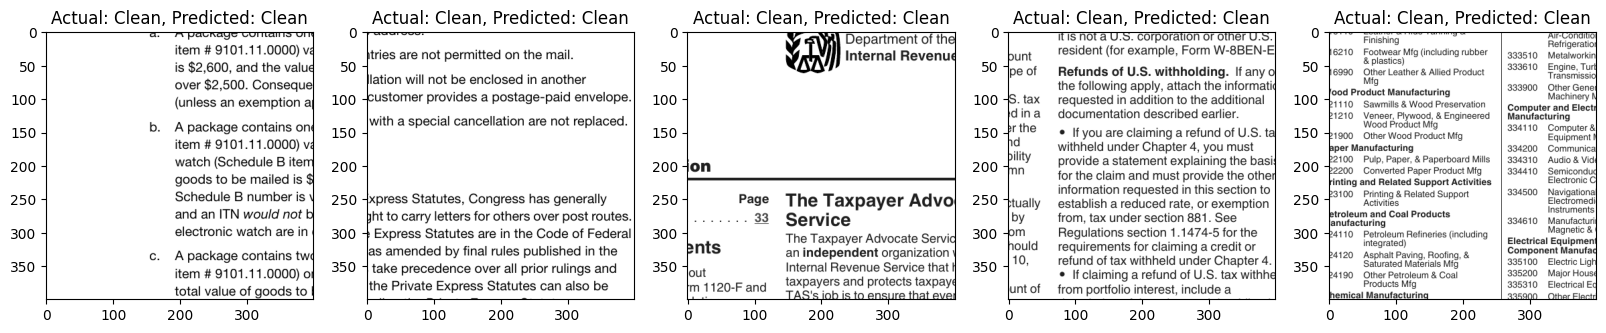

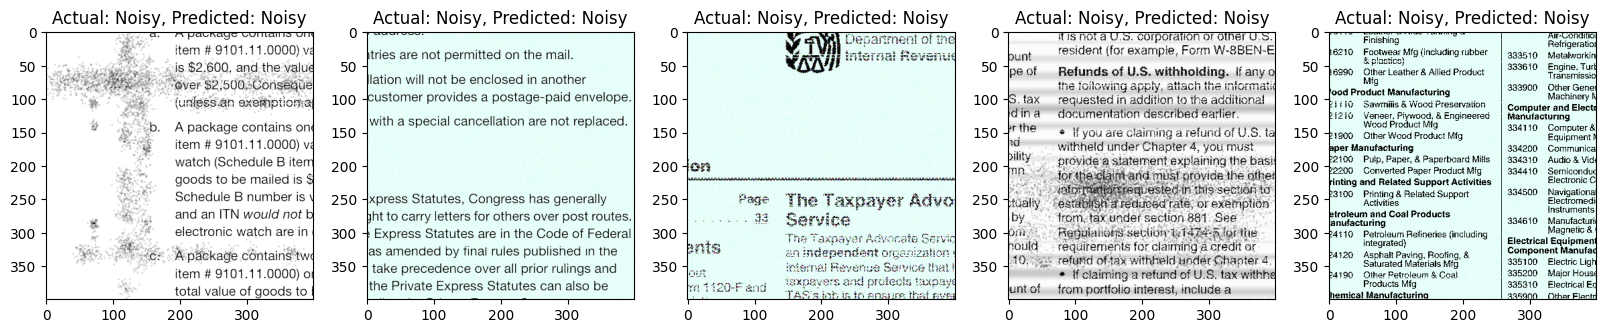

In [ ]:
# Test with test set

plt.rcParams["figure.figsize"] = (20,20)
model.eval()
with torch.no_grad():

    for batch_number, (noisy_samples, clean_samples) in enumerate(zip(validate_dirty_loader, validate_clean_loader)):

        noisy_data = noisy_samples[0].float().to(device)
        noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float().to(device)
        clean_data = clean_samples[0].float().to(device)
        clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float().to(device)

        # predict
        predicted_noisy_labels = model(noisy_data)
        predicted_clean_labels = model(clean_data)

        # Display predictions
        total_images = 5
        plt.figure()
        for i in range(total_images):
            
            plt.subplot(1,total_images,i+1)
            plt.imshow(clean_samples[0][i].reshape(image_size, image_size, 3))
            if predicted_clean_labels[i][0] > 0.5:
                 predicted_label = "Noisy"
            else:
                 predicted_label = "Clean"
            plt.title("Actual: Clean, Predicted: "+predicted_label)
        plt.figure()
        for i in range(total_images):
            plt.subplot(1,total_images,i+1)
            plt.imshow(noisy_samples[0][i].reshape(image_size, image_size, 3))
            if predicted_noisy_labels[i][0] > 0.5:
                 predicted_label = "Noisy"
            else:
                 predicted_label = "Clean"
            plt.title("Actual: Noisy, Predicted: "+predicted_label)

        break
